In [1]:
# imports
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import yfinance as yf

/Users/MilesChild/opt/miniconda3/lib/python3.9/site-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


# Read in Historical One Pagers Log

In [2]:
one_pagers = pd.read_excel('historical_one_pagers.xlsx')
one_pagers.head()

,Publish Date,Semester Code,Ticker,Side,Analyst
0,2024-02-11,S24,TOST,LONG,Cole L
1,2024-02-11,S24,PL,LONG,Cole L
2,2024-01-15,S24,KNT,LONG,Sal
3,2024-01-17,S24,NEO,LONG,Sal
4,2024-02-05,S24,XPEL,LONG,Sal


# Download Historical Price Data

Purge any tickers that we can't get price data for

In [3]:
stock_data = {}
bad_tickers = []
for ticker in one_pagers['Ticker']:
    try:
        stock_data[ticker] = yf.Ticker(ticker).history(period='max')
    except:
        print(f'Could not get data for {ticker}')
        bad_tickers.append(ticker)
        continue

print(f'Bad Tickers: {len(bad_tickers)}')

KRTX: No timezone found, symbol may be delisted
VAIL: No price data found, symbol may be delisted (1d 1925-10-02 -> 2024-09-08)
MAXR: No timezone found, symbol may be delisted
ECOM: No timezone found, symbol may be delisted
SWMA: No timezone found, symbol may be delisted
INSIT: No timezone found, symbol may be delisted
XL: No timezone found, symbol may be delisted
NEWR: No timezone found, symbol may be delisted
NLAB:SS: No timezone found, symbol may be delisted
SNE: No timezone found, symbol may be delisted
VIAC: No timezone found, symbol may be delisted
LOV: No timezone found, symbol may be delisted
SCPL: No timezone found, symbol may be delisted
ALXN: No timezone found, symbol may be delisted
ATH: No timezone found, symbol may be delisted
ETM: No timezone found, symbol may be delisted
PICO: No timezone found, symbol may be delisted
SCPL: No timezone found, symbol may be delisted
NSCO: No timezone found, symbol may be delisted
CVET: No timezone found, symbol may be delisted
FRGI: No t

Bad Tickers: 0


In [4]:
# Remove empty dataframes from stock_data dictionary
stock_data = {ticker: data for ticker, data in stock_data.items() if not data.empty}

# Remove tickers from one_pagers that are not in stock_data
valid_tickers = set(stock_data.keys())
one_pagers = one_pagers[one_pagers['Ticker'].isin(valid_tickers)]

print(f"Number of one pagers after removing invalid tickers: {len(one_pagers)}")

Number of one pagers after removing invalid tickers: 166


# Construct Two Portfolios

1. Rebalance Monthly, Target 20 Holdings
2. Rebalance Monthly, Buy Everything Less Than or Equal to 6mo old

In [5]:
one_pagers['Publish Date'] = pd.to_datetime(one_pagers['Publish Date'])

# Sort one_pagers by 'Publish Date' in descending order
one_pagers_sorted = one_pagers.sort_values('Publish Date', ascending=False)

# Initialize portfolios
portfolio_20 = pd.DataFrame()
portfolio_6mo = pd.DataFrame()

In [6]:
from datetime import datetime, timedelta
import pandas as pd

def construct_portfolios(one_pagers, stock_data):
    # Convert 'Publish Date' to datetime with timezone awareness (UTC)
    one_pagers['Publish Date'] = pd.to_datetime(one_pagers['Publish Date'], utc=True)
    
    # Sort one_pagers by 'Publish Date' in descending order
    one_pagers_sorted = one_pagers.sort_values('Publish Date', ascending=False)
    
    # Initialize portfolios
    portfolio_20 = pd.DataFrame()
    portfolio_6mo = pd.DataFrame()
    
    # Get unique months in the data, ensuring timezone awareness
    months = pd.date_range(start=one_pagers_sorted['Publish Date'].min(),
                           end=one_pagers_sorted['Publish Date'].max(),
                           freq='MS', tz='UTC')
    
    for month_start in months:
        month_end = month_start + pd.offsets.MonthEnd(0)
        month_end = pd.to_datetime(month_end, utc=True)
        
        # Portfolio 1: Rebalance Monthly, Target 20 Holdings
        portfolio_20 = one_pagers_sorted[one_pagers_sorted['Publish Date'] <= month_end].head(20)
        
        # Portfolio 2: Rebalance Monthly, Buy Everything Less Than or Equal to 6mo old
        six_months_ago = month_end - timedelta(days=180)
        portfolio_6mo = one_pagers_sorted[(one_pagers_sorted['Publish Date'] <= month_end) & 
                                          (one_pagers_sorted['Publish Date'] > six_months_ago)]
        
        # Calculate returns for each portfolio
        for portfolio, name in [(portfolio_20, 'Portfolio_20'), (portfolio_6mo, 'Portfolio_6mo')]:
            returns = []
            for ticker in portfolio['Ticker']:
                if ticker in stock_data:
                    stock_returns = stock_data[ticker]['Close'].pct_change()
                    stock_returns = stock_returns[(stock_returns.index >= month_start) & 
                                                  (stock_returns.index <= month_end)]
                    returns.append(stock_returns)
            
            if returns:
                portfolio_return = pd.concat(returns, axis=1).mean(axis=1)
                portfolio_return.name = name
                yield month_start, name, portfolio_return

# Collect the data properly from the generator
data = []
for month_start, portfolio_name, portfolio_return in construct_portfolios(one_pagers, stock_data):
    for date, return_value in portfolio_return.items():
        data.append((month_start, portfolio_name, date, return_value))

# Convert collected data into a DataFrame
portfolio_returns = pd.DataFrame(data, columns=['Month Start', 'Portfolio', 'Date', 'Return'])

# Pivot the DataFrame to get the desired format with 'Portfolio_20' and 'Portfolio_6mo' as columns
pivoted_returns = portfolio_returns.pivot_table(index='Date', columns='Portfolio', values='Return')

# Calculate cumulative returns
cumulative_returns = (1 + pivoted_returns).cumprod()

<Figure size 1200x600 with 0 Axes>

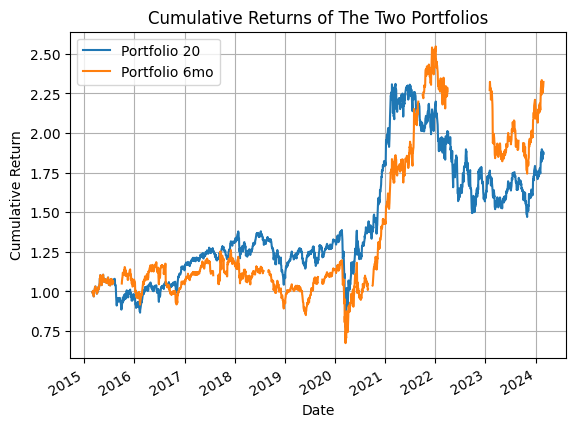

Portfolio  Portfolio_20  Portfolio_6mo
count       2188.000000    1823.000000
mean           0.000391       0.000600
std            0.014473       0.016579
min           -0.130670      -0.131511
25%           -0.006466      -0.006974
50%            0.000774       0.000993
75%            0.007850       0.008932
max            0.115271       0.137050


In [7]:
# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
cumulative_returns.plot()
plt.title('Cumulative Returns of The Two Portfolios')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(['Portfolio 20', 'Portfolio 6mo'])
plt.grid(True)
plt.show()

# Print the descriptive statistics of the portfolio returns
print(pivoted_returns.describe())

[*********************100%%**********************]  1 of 1 completed


<Figure size 1200x600 with 0 Axes>

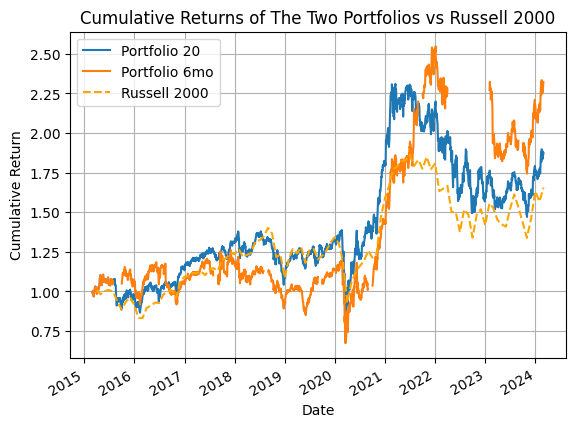

Portfolio  Portfolio_20  Portfolio_6mo
count       2188.000000    1823.000000
mean           0.000391       0.000600
std            0.014473       0.016579
min           -0.130670      -0.131511
25%           -0.006466      -0.006974
50%            0.000774       0.000993
75%            0.007850       0.008932
max            0.115271       0.137050


In [8]:
from datetime import datetime, timedelta
import pandas as pd
import yfinance as yf

def construct_portfolios(one_pagers, stock_data):
    # Convert 'Publish Date' to datetime with timezone awareness (UTC)
    one_pagers['Publish Date'] = pd.to_datetime(one_pagers['Publish Date'], utc=True)
    
    # Sort one_pagers by 'Publish Date' in descending order
    one_pagers_sorted = one_pagers.sort_values('Publish Date', ascending=False)
    
    # Initialize portfolios
    portfolio_20 = pd.DataFrame()
    portfolio_6mo = pd.DataFrame()
    
    # Get unique months in the data, ensuring timezone awareness
    months = pd.date_range(start=one_pagers_sorted['Publish Date'].min(),
                           end=one_pagers_sorted['Publish Date'].max(),
                           freq='MS', tz='UTC')
    
    for month_start in months:
        month_end = month_start + pd.offsets.MonthEnd(0)
        month_end = pd.to_datetime(month_end, utc=True)
        
        # Portfolio 1: Rebalance Monthly, Target 20 Holdings
        portfolio_20 = one_pagers_sorted[one_pagers_sorted['Publish Date'] <= month_end].head(20)
        
        # Portfolio 2: Rebalance Monthly, Buy Everything Less Than or Equal to 6mo old
        six_months_ago = month_end - timedelta(days=180)
        portfolio_6mo = one_pagers_sorted[(one_pagers_sorted['Publish Date'] <= month_end) & 
                                          (one_pagers_sorted['Publish Date'] > six_months_ago)]
        
        # Calculate returns for each portfolio
        for portfolio, name in [(portfolio_20, 'Portfolio_20'), (portfolio_6mo, 'Portfolio_6mo')]:
            returns = []
            for ticker in portfolio['Ticker']:
                if ticker in stock_data:
                    stock_returns = stock_data[ticker]['Close'].pct_change()
                    stock_returns = stock_returns[(stock_returns.index >= month_start) & 
                                                  (stock_returns.index <= month_end)]
                    returns.append(stock_returns)
            
            if returns:
                portfolio_return = pd.concat(returns, axis=1).mean(axis=1)
                portfolio_return.name = name
                yield month_start, name, portfolio_return

# Collect the data properly from the generator
data = []
for month_start, portfolio_name, portfolio_return in construct_portfolios(one_pagers, stock_data):
    for date, return_value in portfolio_return.items():
        data.append((month_start, portfolio_name, date, return_value))

# Convert collected data into a DataFrame
portfolio_returns = pd.DataFrame(data, columns=['Month Start', 'Portfolio', 'Date', 'Return'])

# Pivot the DataFrame to get the desired format with 'Portfolio_20' and 'Portfolio_6mo' as columns
pivoted_returns = portfolio_returns.pivot_table(index='Date', columns='Portfolio', values='Return')

# Calculate cumulative returns for portfolios
cumulative_returns = (1 + pivoted_returns).cumprod()

# Download Russell 2000 (^RUT) data from yfinance
rut_data = yf.download('^RUT', start=cumulative_returns.index.min(), end=cumulative_returns.index.max())

# Calculate daily returns for Russell 2000
rut_data['Return'] = rut_data['Adj Close'].pct_change()

# Resample to monthly returns
rut_monthly_returns = (1 + rut_data['Return']).resample('M').prod() - 1

# Calculate cumulative returns for Russell 2000
rut_cumulative_returns = (1 + rut_monthly_returns).cumprod()

# Plot the results including Russell 2000
plt.figure(figsize=(12, 6))
cumulative_returns.plot()
rut_cumulative_returns.plot(label='Russell 2000', color='orange', linestyle='--')

plt.title('Cumulative Returns of The Two Portfolios vs Russell 2000')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(['Portfolio 20', 'Portfolio 6mo', 'Russell 2000'])
plt.grid(True)
plt.show()

# Print the descriptive statistics of the portfolio returns
print(pivoted_returns.describe())


In [9]:
# Calculate final cumulative returns for the portfolios and Russell 2000
final_cumulative_returns = cumulative_returns.iloc[-1]
final_rut_cumulative_return = rut_cumulative_returns.iloc[-1]

# Print the final cumulative returns
print("Final Cumulative Returns:")
print(f"Portfolio 20: {final_cumulative_returns['Portfolio_20']:.2%}")
print(f"Portfolio 6mo: {final_cumulative_returns['Portfolio_6mo']:.2%}")
print(f"Russell 2000: {final_rut_cumulative_return:.2%}")


Final Cumulative Returns:
Portfolio 20: 186.77%
Portfolio 6mo: 232.12%
Russell 2000: 165.47%
